In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from IPython.display import Image


%load_ext autoreload
%autoreload 2

In [32]:
from model import KMeans, HGrouping, Spectral, loss, rp_loss

In [15]:
df_rp = pd.read_csv('../data/rp_formatted.data', index_col=False, sep='\t', names=[f'x{i}' for i in range(1,10)]+['y'])
cluster_counts = [2]
df_rp['y'] = df_rp['y'].map({2: 0, 4: 1})
df_rp

,x1,x2,x3,x4,x5,x6,x7,x8,x9,y
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1,0
679,2,1,1,1,2,1,1,1,1,0
680,5,10,10,3,7,3,8,10,2,1
681,4,8,6,4,3,4,10,6,1,1


In [43]:
df_18d = pd.read_csv('../data/data_18D.txt', index_col=False, sep='\t', names=[f'x{i}' for i in range(1,19)])
df_18d

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,48,95,83,178,72,10,379,162,42,20,159,176,184,70,6,16,187,197
1,41,91,84,141,57,9,330,149,45,19,143,170,158,72,9,14,189,199
2,50,104,106,209,66,10,635,207,32,23,158,223,220,73,14,9,188,196
3,41,93,82,159,63,9,309,144,46,19,143,160,127,63,6,10,199,207
4,44,85,70,205,103,52,325,149,45,19,144,241,188,127,9,11,180,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,39,93,87,183,64,8,422,169,40,20,134,200,149,72,7,25,188,195
842,46,89,84,163,66,11,368,159,43,20,159,173,176,72,1,20,186,197
843,54,106,101,222,67,12,721,222,30,25,173,228,200,70,3,4,187,201
844,36,86,78,146,58,7,270,135,50,18,124,155,148,66,0,25,190,195


In [45]:
dfs_2d = [pd.read_csv(f'../data/dane_2D_{j}.txt', index_col=False, sep='\t', names=[f'x{i}' for i in range(1,3)]+['y']) for j in range(1, 9)]
cluster_counts = [dfs_2d[i]['y'].unique().size for i in range(8)]

dfs_2d[0]

,x1,x2,y
0,15.55,28.65,2
1,14.90,27.55,2
2,14.45,28.35,2
3,14.15,28.80,2
4,13.75,28.05,2
...,...,...,...
783,7.80,3.35,5
784,8.05,2.75,5
785,8.50,3.25,5
786,8.10,3.55,5


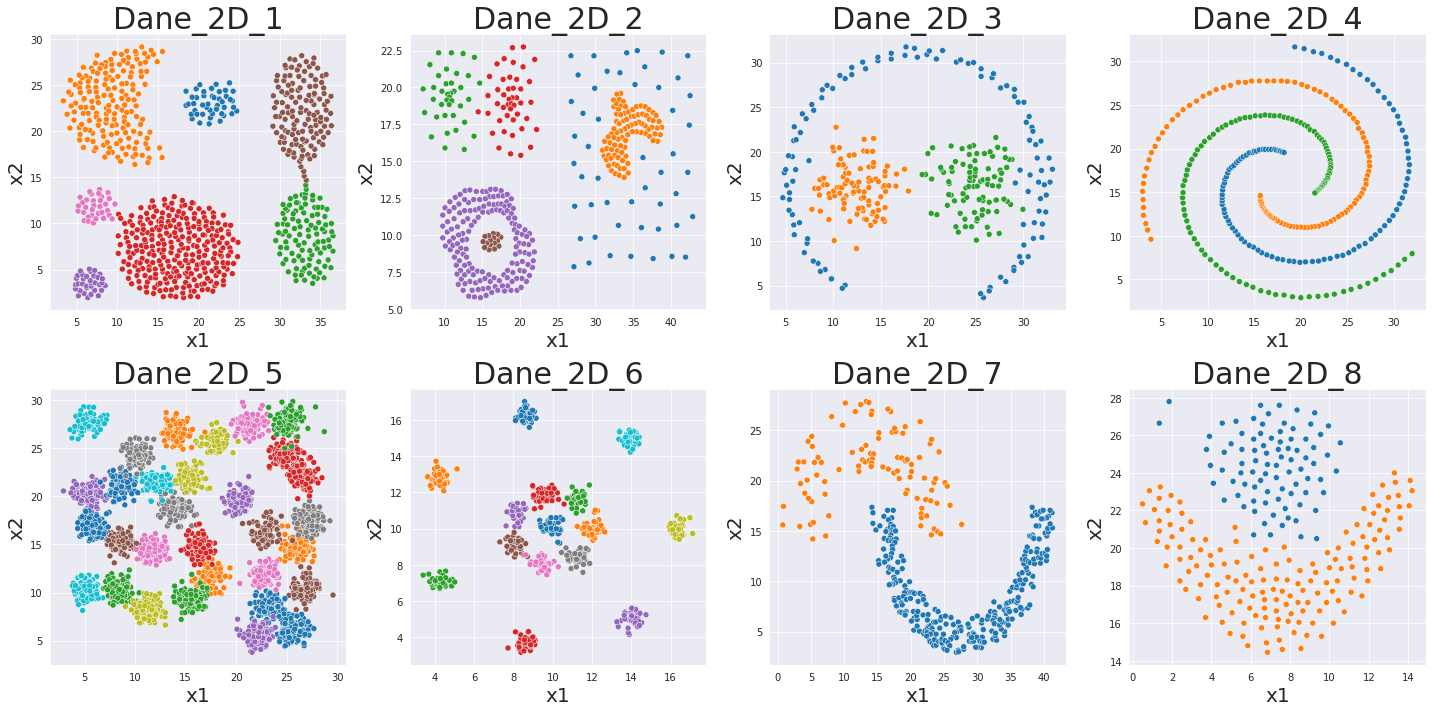

In [135]:
fig, axis = plt.subplots(2, 4, figsize=(20, 10))
axis = axis.flatten()
for i, (ax, df) in enumerate(zip(axis, dfs_2d)):
    sns.scatterplot(x=df['x1'], y=df['x2'], ax=ax, hue=df['y'], palette='tab10')
    sns.move_legend(ax, "center left",  title='Class', title_fontsize='20', fontsize='20')
    ax.legend_.remove()
    ax.set_xlabel('x1', fontsize=20)
    ax.set_ylabel('x2', fontsize=20)
    ax.set_title(f'Dane_2D_{i+1}', fontsize=30)
    plt.tight_layout()

In [47]:
class MinMaxScaler:
    def __init__(self, A):
        self.shift = A.min(axis=0)
        self.factor = A.max(axis=0)-A.min(axis=0)

    def scale(self, A):
        return (A-self.shift)/self.factor

def scale(df, scaler):
    # df_scaled = scaler.scale(df.drop('y', axis=1))
    # df_scaled['y'] = df['y']
    df_scaled = scaler.scale(df)
    return df_scaled

# for i in range(8):
#     scaler = MinMaxScaler(dfs_2d[i])
#     dfs_2d[i] = scale(dfs_2d[i], scaler)
# dfs_2d[0]

# scaler = MinMaxScaler(df_rp)
# df_rp = scale(df_rp, scaler)
# df_rp

scaler = MinMaxScaler(df_18d)
df_18d = scale(df_18d, scaler)
df_18d

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
0,0.576923,0.478261,0.597222,0.323144,0.274725,0.150943,0.233813,0.326797,0.457143,0.250000,0.585714,0.242105,0.471698,0.144737,0.272727,0.390244,0.366667,0.533333
1,0.307692,0.391304,0.611111,0.161572,0.109890,0.132075,0.175060,0.241830,0.542857,0.166667,0.357143,0.210526,0.308176,0.171053,0.409091,0.341463,0.433333,0.600000
2,0.653846,0.673913,0.916667,0.458515,0.208791,0.150943,0.540767,0.620915,0.171429,0.500000,0.571429,0.489474,0.698113,0.184211,0.636364,0.219512,0.400000,0.500000
3,0.307692,0.434783,0.583333,0.240175,0.175824,0.132075,0.149880,0.209150,0.571429,0.166667,0.357143,0.157895,0.113208,0.052632,0.272727,0.243902,0.766667,0.866667
4,0.423077,0.260870,0.416667,0.441048,0.615385,0.943396,0.169065,0.241830,0.542857,0.166667,0.371429,0.584211,0.496855,0.894737,0.409091,0.268293,0.133333,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,0.230769,0.434783,0.652778,0.344978,0.186813,0.113208,0.285372,0.372549,0.400000,0.250000,0.228571,0.368421,0.251572,0.171053,0.318182,0.609756,0.400000,0.466667
842,0.500000,0.347826,0.611111,0.257642,0.208791,0.169811,0.220624,0.307190,0.485714,0.250000,0.585714,0.226316,0.421384,0.171053,0.045455,0.487805,0.333333,0.533333
843,0.807692,0.717391,0.847222,0.515284,0.219780,0.188679,0.643885,0.718954,0.114286,0.666667,0.785714,0.515789,0.572327,0.144737,0.136364,0.097561,0.366667,0.666667
844,0.115385,0.282609,0.527778,0.183406,0.120879,0.094340,0.103118,0.150327,0.685714,0.083333,0.085714,0.131579,0.245283,0.092105,0.000000,0.609756,0.466667,0.466667


In [49]:
def get_data(df):
    # y = df['y'].to_numpy()
    # y = y.reshape([y.shape[0], 1])

    # X = df.drop('y', axis=1)
    # X = X.to_numpy()
    X=df.to_numpy()
    y=None

    return X, y


# X, true_y = [], []
# for i in range(8):
#     _X, _true_y = get_data(dfs_2d[i])
#     X += [_X]
#     true_y += [_true_y]
# print("X: ", X[0].shape)
# print("y: ", true_y[0].shape)

# X, true_y = [], []
# for i in range(1):
#     _X, _true_y = get_data(df_rp)
#     X += [_X]
#     true_y += [_true_y]
# print("X: ", X[0].shape)
# print("y: ", true_y[0].shape)

X = []
for i in range(1):
    _X, _true_y = get_data(df_18d)
    X += [_X]
print("X: ", X[0].shape)

X:  (846, 18)


# K - Means

In [33]:
models = []
y_pred = []
for i in range(1):
    y_pred += [[]]
    models += [[]]
    for j in range(10):
        model = KMeans(c)
        models[i] += [model]
        y_pred[i] += [model.train(X[i], 1000, seed=j)]

100%|██████████| 1000/1000 [00:00<00:00, 12023.82it/s]


In [70]:
models = []
y_pred = []
for c in tqdm(range(2, 50)):
    models += [[]]
    y_pred += [[]]
    for j in range(1):
        model = KMeans(c)
        models[c-2] += [model]
        y_pred[c-2] += [model.train(X[0], 1000, seed=j)]

100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


In [71]:
errors = []
for i, m in enumerate(models):
    errors += [min([m[j].error() for j in range(1)])]
    print(f'{i+2} clusters: {errors[-1]}')

2 clusters: 490.1266829264038
3 clusters: 435.4166528690085
4 clusters: 412.11520684301627
5 clusters: 394.31016875188834
6 clusters: 383.72248660892274
7 clusters: 370.40141315188083
8 clusters: 359.84511063887174
9 clusters: 349.7215268102449
10 clusters: 342.8811550265814
11 clusters: 336.4011076612323
12 clusters: 331.44277786967365
13 clusters: 318.8816919907127
14 clusters: 313.32222460228576
15 clusters: 305.45171062714843
16 clusters: 301.13547765643204
17 clusters: 297.46394774704055
18 clusters: 293.0865610557471
19 clusters: 290.65063283553457
20 clusters: 289.3855409680434
21 clusters: 283.97611775842194
22 clusters: 280.5003156533094
23 clusters: 278.04530738602637
24 clusters: 274.1193510782629
25 clusters: 272.2591375710834
26 clusters: 269.4580964599672
27 clusters: 267.8688189878589
28 clusters: 265.16975791140777
29 clusters: 262.3359333856886
30 clusters: 260.5692686702311
31 clusters: 259.4946569327871
32 clusters: 254.88681981971752
33 clusters: 254.421902935371
34

<Axes: xlabel='clusters', ylabel='error'>

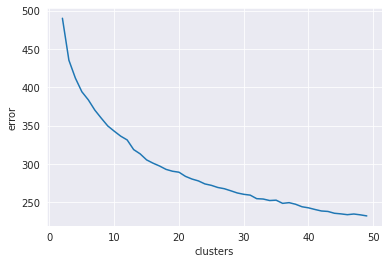

In [73]:
df = {'clusters': [x for x in range(2, 50)], 'error': [x for x in errors]}
sns.lineplot(df, x='clusters', y='error')

In [35]:
losses = []
for i in tqdm(range(1)):
    losses += [[rp_loss(true_y[i], y_pred[i][j]) for j in range(10)]]
max(losses[0])

100%|██████████| 1/1 [00:00<00:00, 972.03it/s]


0.9619326500732065

In [ ]:
fig, axis = plt.subplots(4, 4, figsize=(20, 20))
for i in range(8):
    best = max(range(10), key=lambda x: losses[i][x])
    print(f'Best loss for model {i+1}: {losses[i][best]}')
    
    m = models[i][best]
    mi_df = pd.DataFrame({'x1': m.mi[:, 0], 'x2': m.mi[:, 1]})
    X_df = pd.DataFrame({'x1': m.X[:, 0], 'x2': m.X[:, 1], 'c': m.clusters})

    sns.scatterplot(x=mi_df['x1'], y=mi_df['x2'], ax=axis[i//2][2*(i%2) +0], marker='X', hue=mi_df.index, s=500, zorder=10, palette='tab10')
    sns.scatterplot(x=X_df['x1'], y=X_df['x2'], ax=axis[i//2][2*(i%2) +0], hue=X_df['c'], palette='tab10')
    
    sns.scatterplot(x=X_df['x1'], y=X_df['x2'], ax=axis[i//2][2*(i%2) + 1], hue=dfs_2d[i]['y'], palette='tab10')

    for j in range(2):
        ax = axis[i//2][2*(i%2)+j]
        ax.set_xlabel('x1', fontsize=15)
        ax.set_ylabel('x2', fontsize=15)
        ax.set_title(f'Dane_2D_{i+1}', fontsize=20)
        ax.legend_.remove()
plt.tight_layout()

# Grupowanie Hierarchiczne

In [36]:
join_types = ['single', 'full', 'mean', 'centroid', 'ward']
models=[]
y_pred=[]
for i in range(1):
    models += [[]]
    y_pred += [[]]
    for jt in join_types:
        model = HGrouping(cluster_counts[i])
        models[i] += [model]
        y_pred[i] += [model.train(X[i], jt)]

100%|██████████| 681/681 [00:00<00:00, 845.41it/s]


In [38]:
losses = []
for i in tqdm(range(1)):
    losses += [[rp_loss(true_y[i], y_pred[i][j]) for j in range(len(join_types))]]
losses

100%|██████████| 1/1 [00:00<00:00, 2038.05it/s]


[[0.6515373352855052,
  0.8404099560761347,
  0.9428989751098097,
  0.6515373352855052,
  0.9633967789165446]]

Best loss for model 1: 1.0 - centroid
Best loss for model 2: 0.9164368206949535 - mean
Best loss for model 3: 0.7379264214046822 - mean
Best loss for model 4: 1.0 - single
Best loss for model 5: 0.9948520334343024 - ward
Best loss for model 6: 0.998692264885921 - mean
Best loss for model 7: 0.8839689815215198 - full
Best loss for model 8: 0.7210599721059973 - mean


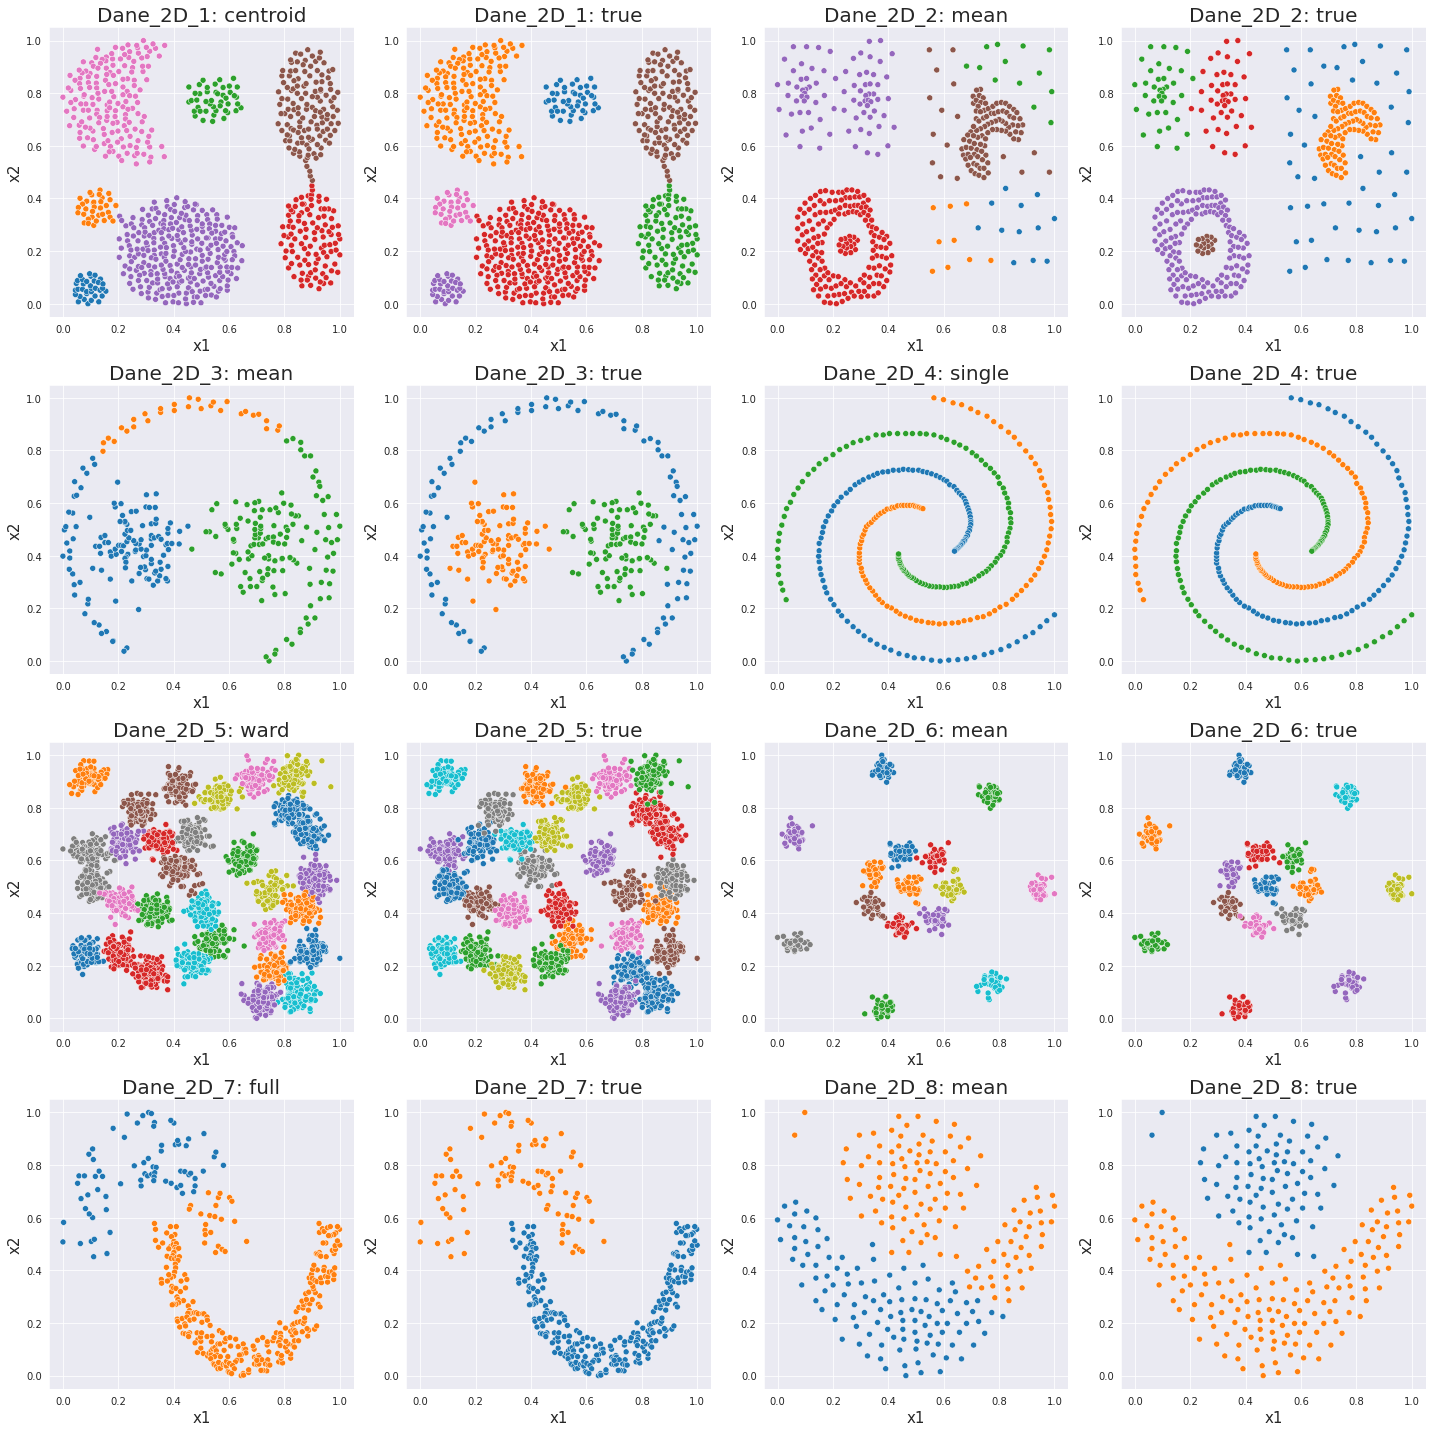

In [197]:
fig, axis = plt.subplots(4, 4, figsize=(20, 20))
for i in range(8):
    best = max(range(len(join_types)), key=lambda x: losses[i][x])
    print(f'Best loss for model {i+1}: {losses[i][best]} - {join_types[best]}')
    
    m = models[i][best]
    X_df = pd.DataFrame({'x1': m.X[:, 0], 'x2': m.X[:, 1], 'c': m.c})
    
    sns.scatterplot(x=X_df['x1'], y=X_df['x2'], ax=axis[i//2][2*(i%2) +0], hue=X_df['c'], palette='tab10')
    
    sns.scatterplot(x=X_df['x1'], y=X_df['x2'], ax=axis[i//2][2*(i%2) + 1], hue=dfs_2d[i]['y'], palette='tab10')
    
    for j in range(2):
        ax = axis[i//2][2*(i%2)+j]
        ax.set_xlabel('x1', fontsize=15)
        ax.set_ylabel('x2', fontsize=15)
        if j==0:
            ax.set_title(f'Dane_2D_{i+1}: {join_types[best]}', fontsize=20)
        else:
            ax.set_title(f'Dane_2D_{i+1}: true', fontsize=20)
        ax.legend_.remove()
        plt.tight_layout()

# Klasteryzacja Spektralna

In [39]:
models = []
y_pred = []
for i in range(1):
    models += [[]]
    y_pred += [[]]
    for j in range(10):
        model = Spectral(cluster_counts[i])
        models[i] += [model]
        y_pred[i] += [model.train(X[i], seed=j)]

100%|██████████| 1000/1000 [00:00<00:00, 10870.47it/s]


In [40]:
losses = []
for i in tqdm(range(1)):
    losses += [[rp_loss(true_y[i], y_pred[i][j]) for j in range(10)]]
max(losses[0])

100%|██████████| 1/1 [00:00<00:00, 1050.68it/s]


0.9677891654465594

Best loss for model 1: 0.9990131515296151
Best loss for model 2: 0.848339441568746
Best loss for model 3: 0.7536008918617614
Best loss for model 4: 0.3936845576716959
Best loss for model 5: 0.9961425641986489
Best loss for model 6: 0.9982526432943796
Best loss for model 7: 0.7594049987027588
Best loss for model 8: 0.6837168758716876


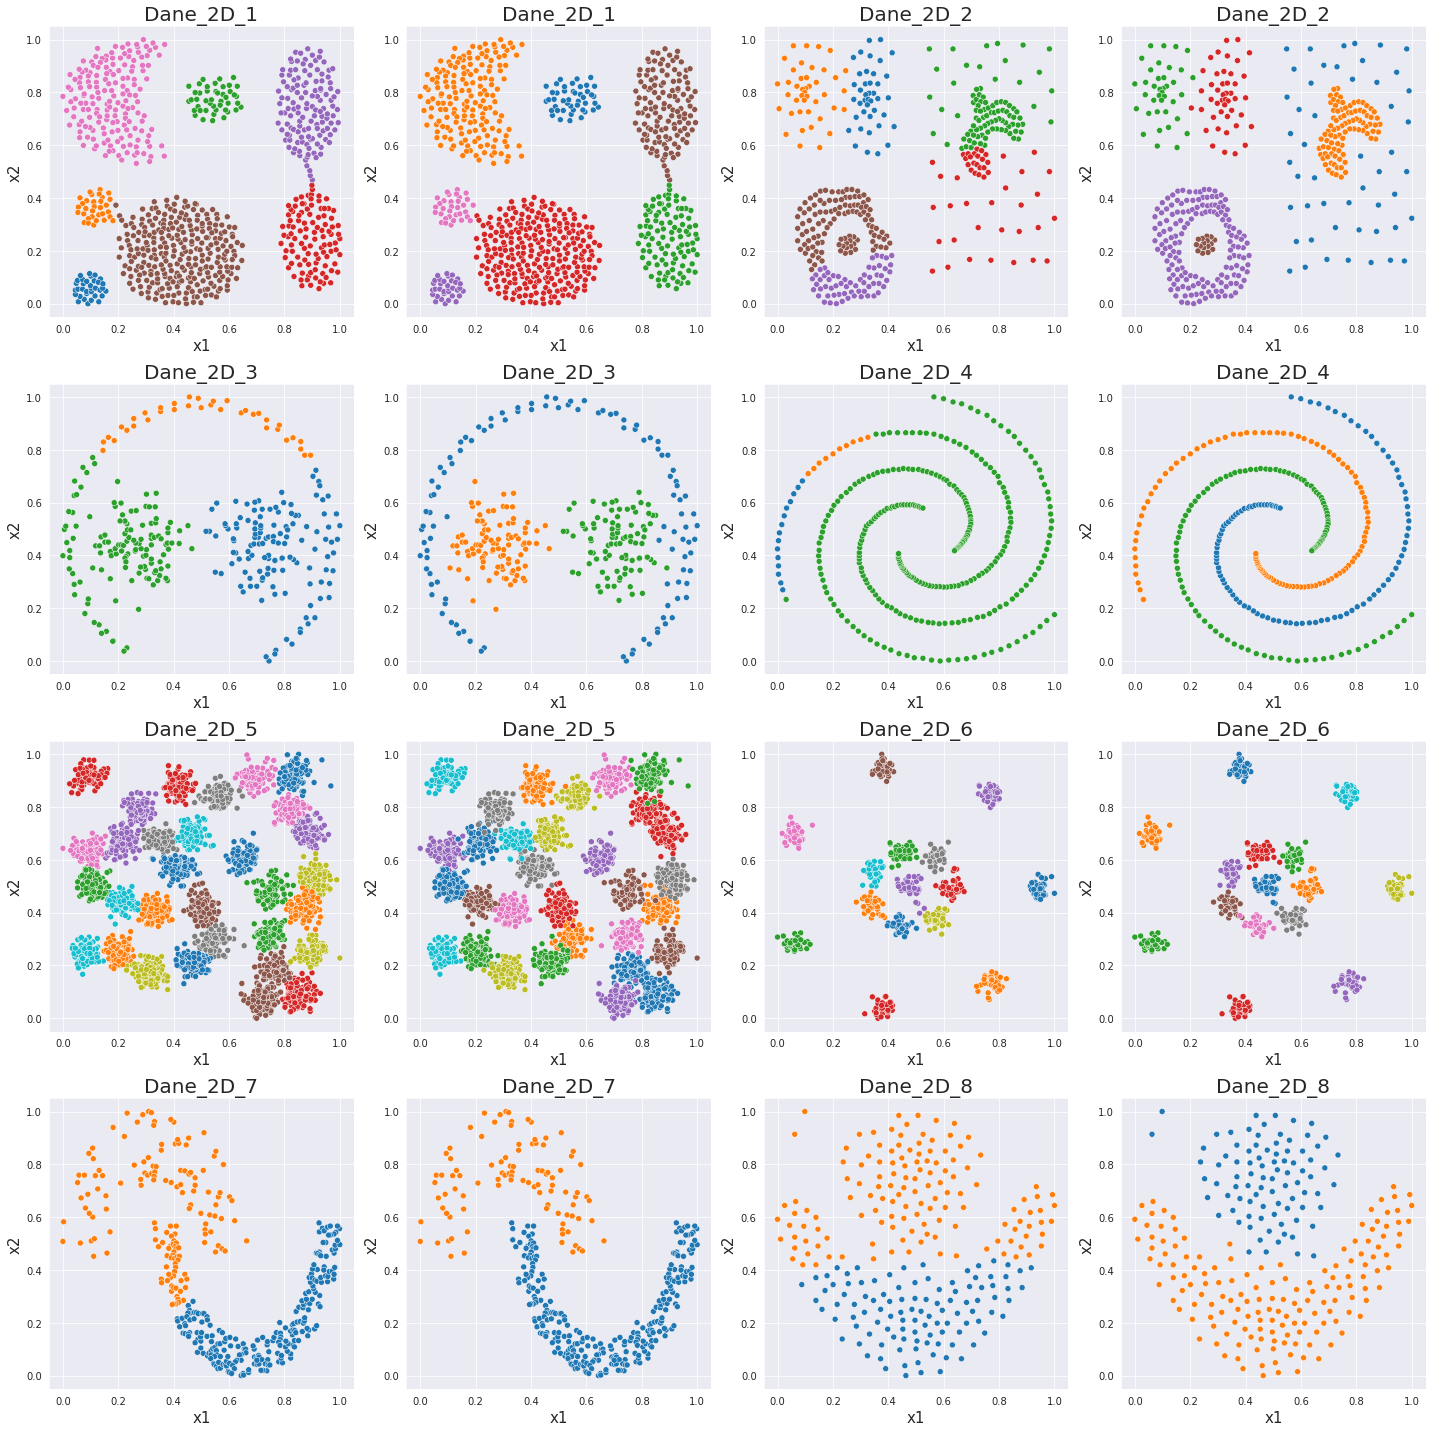

In [216]:
fig, axis = plt.subplots(4, 4, figsize=(20, 20))
for i in range(8):
    best = max(range(1), key=lambda x: losses[i][x])
    print(f'Best loss for model {i+1}: {losses[i][best]}')

    m = models[i][best]
    X_df = pd.DataFrame({'x1': m.X[:, 0], 'x2': m.X[:, 1], 'c': m.c})

    sns.scatterplot(x=X_df['x1'], y=X_df['x2'], ax=axis[i//2][2*(i%2) +0], hue=X_df['c'], palette='tab10')

    sns.scatterplot(x=X_df['x1'], y=X_df['x2'], ax=axis[i//2][2*(i%2) + 1], hue=dfs_2d[i]['y'], palette='tab10')

    for j in range(2):
        ax = axis[i//2][2*(i%2)+j]
        ax.set_xlabel('x1', fontsize=15)
        ax.set_ylabel('x2', fontsize=15)
        ax.set_title(f'Dane_2D_{i+1}', fontsize=20)
        ax.legend_.remove()
plt.tight_layout()